## Importing necessary libraries

In [1]:
%matplotlib inline
import numpy as np #linear algebra library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt #plotting library
import seaborn as sns # plotting library with more features

## Reading in data

In [2]:
df1 = pd.read_csv('internship_task/data/CMO_MSP_Mandi.csv')
df2 = pd.read_csv('internship_task/data/Monthly_data_cmo.csv',index_col=0, parse_dates = [[2,3]], infer_datetime_format = True ) # Since, columns Year and Month will be used for time series analysis.
# infer_datetime_format is usually the fastest method, date_parser can also be used with infer parameter = False,
# don't know why index_col = 0 , rather than 3 for 'Year', but it seems date parsing is done first and then the 
# Year_Month column becomes the first column, so automatically as you can see column becomes 0th.

In [3]:
df1.head() #Displaying head of data for MSP

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


In [4]:
df2.head() #Displaying head of data for Monthly Mandi arrivals, prices ,etc.

,APMC,Commodity,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
Year_Month,,,,,,,,,
2015-04-01,Ahmednagar,Bajri,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Bajri,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Wheat(Husked),1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
2016-04-01,Ahmednagar,Wheat(Husked),387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
2015-04-01,Ahmednagar,Sorgum(Jawar),3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra


In [5]:
type(df2.index) # But ,we would rather like it to be a period index with frequency 'M', so converting next!

pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
df2 = df2.to_period(freq='M') #Converting to period index with monthly frequency. I think PeriodIndex will be best,
# since we are looking at the whole month and not just the first day of the month
type(df2.index)

pandas.core.indexes.period.PeriodIndex

## Exploring the DataFrame df1 , for MSP

### The dataset is of 155 instances and 5 columns

In [8]:
df1.shape # It contains 155 instances with 5 columns

(155, 5)

### Seeing below count of msprice is 145, so it contains 10 missing data points ; year,msp_filter, commodity and Type don't contain any missing data.

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
commodity     155 non-null object
year          155 non-null int64
Type          155 non-null object
msprice       145 non-null float64
msp_filter    155 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.1+ KB


### Commodity has 32 unique values, Type has 3 unique values, for numeric data types i.e, np.number unique, top ,etc are not given

In [10]:
df1.describe(include = 'all')

,commodity,year,Type,msprice,msp_filter
count,155,155.000000,155,145.000000,155.0
unique,32,NaN,3,NaN,NaN
top,Copra (Ball)_Yellow,NaN,Kharif Crops,NaN,NaN
freq,5,NaN,90,NaN,NaN
mean,NaN,2014.000000,NaN,2822.448276,1.0
std,NaN,1.418798,NaN,1441.725928,0.0
min,NaN,2012.000000,NaN,170.000000,1.0
25%,NaN,2013.000000,NaN,1470.000000,1.0
50%,NaN,2014.000000,NaN,2970.000000,1.0
75%,NaN,2015.000000,NaN,4000.000000,1.0


#### Below, we can see that msp_filter has only unique value of 1, thus, we can drop this column since it doesn't provide us any utility.

In [11]:
df1['msp_filter'].unique()

array([1])

In [12]:
df1 = df1.drop('msp_filter', axis=1) #Dropping msp_filter

In [13]:
df1['year'].unique() # Five years are summarized in the dataset 2012, 2013, 2014, 2015 and 2016

array([2012, 2013, 2014, 2015, 2016])

### Now, I'll try to summarize CMO_MSP_Mandi.csv dataset. It contains four columns:(after removing msp_filter)
>  #### 1) commodity - Which contains 32 unique values, and gives different types of crops according to the seasons.
>  #### 2) year : We have data for five years from 2012 to 2016.
>  #### 3) Type : Whether the commodity is a Kharif crop, Rabi crop or other crop.
>  #### 4) msp_price - Gives the minimum support price for a commodity, since we have yearly data for each crop,  we have 5 data points of msp for each commodity/crop.


## For df1 my aim is to  remove any outliers and then impute the 10 missing values in the data.

In [16]:
#Initially, I always try to go with the boxplot for outlier analysis, since the points lying at the other end
#the whiskers, can be removed as outliers when the distribution can be considered to be normal, even if distribution
#isn't normal, it can be converted to normal distribution such as in the case of lognormal plots,etc. We have the
#scipy method of boxcox to help us out in this. I've given the plots for the plots that I did try, even though some
#may be pointless, but from the point of curiousity.

### I don't have much experience with outlier analysis, so took help of some medium blogposts, analythics vidhya, kdnuggets, etc.
__[Ways to Detect and Remove the Outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)__ 

__[A Brief Overview of Outlier Detection Techniques](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)__

__[Outlier](https://en.wikipedia.org/wiki/Outlier)__

And many more

In [18]:
# Remove the pound symbol to get access to the code, this is boxplot of msprices
# %load snippets/msp_boxplot.py

In [19]:
# Histogram of msprices.
# %load snippets/msp_distplot.py

#### The boxplot below suggests that there are no outliers in "msprice" vs "type of crop"

In [26]:
# %load snippets/msp_croptype_boxplot.py

### Bar plot

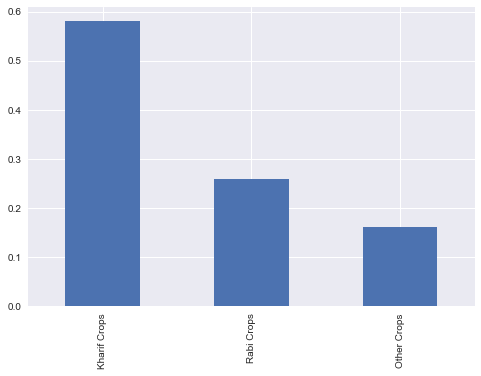

In [21]:
(df1['Type'].value_counts()/len(df1)).plot.bar() #More Kharif crops than Rabi crops?

### Histogram Plot

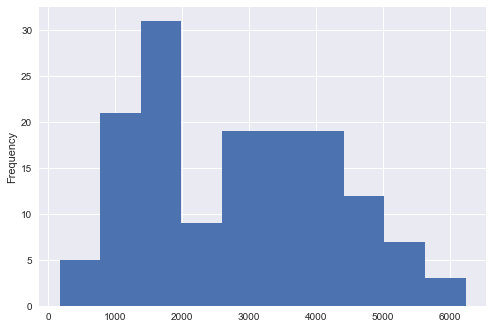

In [27]:
df1['msprice'].plot.hist()

### I don't think we can use a boxplot for msprice to remove outliers, not that the distribution isn't  a normal distribution, but since the prices of the same crop should be compared to itself, say Sugarcane like given below: msprice for 2012 is 170, for 2013 its 210, for 2014 its 220,etc. If we have high priced crops such as copra which is worth 6240 in large numbers then in the distribution then understandably sugarcane would turn out to be the outliers, since their prices are very less. So, for outlier detection the prices of the same crop should be compared.


#### A similar example would be the salary of employees in a firm , say 50 people work there, out of the 50 - 5 are at the management level, 5 are working at manual workers level, and 40 are working as regular employees. The salaries of regular employees may fall between say 50k to 100k per month, for a manual worker it might be from 5k to 8k, then for management level it might be 1million to 5million ( tyrannyical monopoly :D) , so automatically the manual workers and the management are the outliers. But, basically we should be drawing comparison on the basis of salary in the group level i.e, the hierarchy of management, regular employees, and manual labour. Similar is the case for the given problem.

In [30]:
df1.sort_values(by='msprice', ascending=True).head() #Below, we can see the msprices of sugarcane

,commodity,year,Type,msprice
30,SUGAR-CANE,2012,Other Crops,170.0
61,SUGAR-CANE,2013,Other Crops,210.0
92,SUGAR-CANE,2014,Other Crops,220.0
154,SUGARCANE,2016,Other Crops,230.0
123,SUGAR-CANE,2015,Other Crops,230.0


In [33]:
df1.sort_values(by='msprice', ascending=False).head()  #msprice for copra which is a very high priced crop in terms
# of msp, compared to the others.

,commodity,year,Type,msprice
151,Copra (Ball)_Yellow,2016,Other Crops,6240.0
150,Copra (Milling)_Yellow,2016,Other Crops,5950.0
120,Copra (Ball)_Yellow,2015,Other Crops,5830.0
119,Copra (Milling)_Yellow,2015,Other Crops,5550.0
89,Copra (Ball)_Yellow,2014,Other Crops,5500.0


### I was thinking of doing a groupby on commodity, and then taking the z-scores after necessary transformation to get the outliers by removing mprices with more than 3 absolute standard deviations. But, since the number of points in that case would be 5 per crop, I don't think it's possible to apply this, method.

#### So, currently I'll leave the outlier detection for df1 and move on to the imputation of the missing values

### Mean Value imputation

In [36]:
df3 = df1.loc[df1['msprice'].isnull(), 'commodity'] #df3 gives the commodities with the missing values

In [37]:
dict = {}
for group, frame in df1[df1['commodity'].isin(df3.tolist())].groupby('commodity'):
    dict[group] = frame['msprice'].mean()

In [39]:
dict #Commodities with missing values with their means for the remaining years for mean value imputation.

{'BARLI': 1113.75,
 'Gram_Yellow': 3175.0,
 'MUSTARD': 3125.0,
 'Masur_Yellow': 3062.5,
 'SAFFLOWER': 3037.5,
 'Soyabean_Black': 2400.0,
 'Toria_Yellow': 3075.0,
 'WHEAT(HUSKED)': 1431.25,
 'WHEAT(UNHUSKED)': 1431.25}

In [40]:
for key, value in dict.items():
    df1.loc[(df1['commodity'] == key) & (df1['msprice'].isnull()), 'msprice']  = value

In [42]:
df1.info() #Mean values have been successfully imputed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 4 columns):
commodity    155 non-null object
year         155 non-null int64
Type         155 non-null object
msprice      155 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.9+ KB
